In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from keras.models import Model

from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import *


import sys

from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dense
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from keras.layers.advanced_activations import ELU, LeakyReLU
#from metric import dice_coef, dice_coef_loss



IMG_ROWS, IMG_COLS = 128, 128 

/home/root2/root@123/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

def _shortcut(_input, residual):
    stride_width = _input._keras_shape[2] / residual._keras_shape[2]
    stride_height = _input._keras_shape[3] / residual._keras_shape[3]
    equal_channels = residual._keras_shape[1] == _input._keras_shape[1]

    shortcut = _input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = AtrousConvolution2D(nb_filter=residual._keras_shape[1], nb_row=1, nb_col=1,
                                 subsample=(stride_width, stride_height),
                                 init="he_normal", border_mode="valid",atrous_rate=(2,2))(_input)

    return merge([shortcut, residual], mode="sum")




def inception_block(inputs, depth, batch_mode, splitted=False, activation='relu'):
    assert depth % 16 == 0
    actv = activation == 'relu' and (lambda: LeakyReLU(0.0)) or activation == 'elu' and (lambda: ELU(1.0)) or None
    
    c1_1 = AtrousConvolution2D(int(depth/4), 1, 1, border_mode='same',atrous_rate=(2,2))(inputs)
    
    c2_1 = AtrousConvolution2D(int(depth/8*3), 1, 1, init='he_normal', border_mode='same',atrous_rate=(2,2))(c1_1)
    c2_1 = actv()(c2_1)
    if splitted:
        c2_2 = AtrousConvolution2D(int(depth/2), 1, 3, init='he_normal', border_mode='same',atrous_rate=(2,2))(c2_1)
        c2_2 = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True)(c2_2)
        c2_2 = actv()(c2_2)
        c2_3 = AtrousConvolution2D(int(depth/2), 3, 1, init='he_normal', border_mode='same',atrous_rate=(2,2))(c2_2)
    else:
        c2_3 = AtrousConvolution2D(int(depth/2), 3, 3, init='he_normal', border_mode='same',atrous_rate=(2,2))(c2_1)
    
    c3_1 = AtrousConvolution2D(int(depth/16), 1, 1, init='he_normal', border_mode='same',atrous_rate=(2,2))(inputs)
    #missed batch norm
    c3_1 = actv()(c3_1)
    if splitted:
        c3_2 = AtrousConvolution2D(int(depth/8), 1, 5, init='he_normal', border_mode='same',atrous_rate=(2,2))(c3_1)
        c3_2 = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True )(c3_2)
        c3_2 = actv()(c3_2)
        c3_3 = AtrousConvolution2D(int(depth/8), 5, 1, init='he_normal', border_mode='same',atrous_rate=(2,2))(c3_2)
    else:
        c3_3 = AtrousConvolution2D(int(depth/8), 5, 5, init='he_normal', border_mode='same',atrous_rate=(2,2))(c3_1)
    
    p4_1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), border_mode='same')(inputs)
    c4_2 = AtrousConvolution2D(int(depth/8), 1, 1, init='he_normal', border_mode='same',atrous_rate=(2,2))(p4_1)
    
    res = merge([c1_1, c2_3, c3_3, c4_2], mode='concat', concat_axis=3)
    res = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True)(res)
    res = actv()(res)
    return res


def rblock(inputs, num, depth, scale=0.1):    
    residual = AtrousConvolution2D(depth, num, num, border_mode='same',atrous_rate=(2,2))(inputs)
    residual = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True)(residual)
    residual = Lambda(lambda x: x*scale)(residual)
    res = _shortcut(inputs, residual)
    return ELU()(res) 
    

def NConvolution2D(nb_filter, nb_row, nb_col, border_mode='same', subsample=(1, 1)):
    def f(_input):
        conv = AtrousConvolution2D(nb_filter=nb_filter, nb_row=nb_row, nb_col=nb_col, subsample=subsample,
                              border_mode=border_mode)(_input)
        norm = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True)(conv)
        return ELU()(norm)

    return f

def BNA(_input):
    inputs_norm = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True)(_input)
    return ELU()(inputs_norm)

def reduction_a(inputs, k=64, l=64, m=96, n=96):
    "35x35 -> 17x17"
    inputs_norm = BNA(inputs)
    pool1 = MaxPooling2D((3,3), strides=(2,2), border_mode='same')(inputs_norm)
    
    conv2 = AtrousConvolution2D(n, 3, 3, subsample=(2,2), border_mode='same',atrous_rate=(2,2))(inputs_norm)
    
    conv3_1 = NConvolution2D(k, 1, 1, subsample=(1,1), border_mode='same')(inputs_norm)
    conv3_2 = NConvolution2D(l, 3, 3, subsample=(1,1), border_mode='same')(conv3_1)
    conv3_2 = AtrousConvolution2D(m, 3, 3, subsample=(2,2), border_mode='same',atrous_rate=(2,2))(conv3_2)
    
    res = merge([pool1, conv2, conv3_2], mode='concat', concat_axis=1)
    return res


def reduction_b(inputs):
    "17x17 -> 8x8"
    inputs_norm = BNA(inputs)
    pool1 = MaxPooling2D((3,3), strides=(2,2), border_mode='same')(inputs_norm)
    #
    conv2_1 = NConvolution2D(64, 1, 1, subsample=(1,1), border_mode='same')(inputs_norm)
    conv2_2 = AtrousConvolution2D(96, 3, 3, subsample=(2,2), border_mode='same',atrous_rate=(2,2))(conv2_1)
    #
    conv3_1 = NConvolution2D(64, 1, 1, subsample=(1,1), border_mode='same')(inputs_norm)
    conv3_2 = AtrousConvolution2D(72, 3, 3, subsample=(2,2), border_mode='same',atrous_rate=(2,2))(conv3_1)
    #
    conv4_1 = NConvolution2D(64, 1, 1, subsample=(1,1), border_mode='same')(inputs_norm)
    conv4_2 = NConvolution2D(72, 3, 3, subsample=(1,1), border_mode='same')(conv4_1)
    conv4_3 = AtrousConvolution2D(80, 3, 3, subsample=(2,2), border_mode='same',atrous_rate=(2,2))(conv4_2)
    #
    res = merge([pool1, conv2_2, conv3_2, conv4_3], mode='concat', concat_axis=1)
    return res



smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
def get_unet_inception_2head(optimizer):
    splitted = False
    act = 'elu'
    
    inputs = Input(shape=(IMG_ROWS, IMG_COLS,1))
    conv1 = inception_block(inputs, 64, batch_mode=2, splitted=splitted, activation=act)
    #conv1 = inception_block(conv1, 32, batch_mode=2, splitted=splitted, activation=act)
    
    #pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = NConvolution2D(32, 3, 3, border_mode='same', subsample=(2,2))(conv1)
    pool1 = Dropout(0.5)(pool1)
    
    conv2 = inception_block(pool1, 128, batch_mode=2, splitted=splitted, activation=act)
    #pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = NConvolution2D(128, 3, 3, border_mode='same', subsample=(2,2))(conv2)
    pool2 = Dropout(0.5)(pool2)
    
    conv3 = inception_block(pool2, 256, batch_mode=2, splitted=splitted, activation=act)
    #pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = NConvolution2D(256, 3, 3, border_mode='same', subsample=(2,2))(conv3)
    pool3 = Dropout(0.5)(pool3)
     
        
    conv4 = inception_block(pool3, 512, batch_mode=2, splitted=splitted, activation=act)
    #print(conv4.shape)
    #pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = NConvolution2D(512, 3, 3, border_mode='same', subsample=(2,2))(conv4)
    pool4 = Dropout(0.5)(pool4)
    
    conv5 = inception_block(pool4, 512, batch_mode=2, splitted=splitted, activation=act)
    #conv5 = inception_block(conv5, 512, batch_mode=2, splitted=splitted, activation=act)
    conv5 = Dropout(0.5)(conv5)
    #print(conv5.shape)
    
    #
    pre = AtrousConvolution2D(1, 1, 1, init='he_normal', activation='sigmoid',atrous_rate=(2,2),)(conv5)
    pre = Flatten()(pre)
    aux_out = Dense(1, activation='sigmoid', name='aux_output')(pre) 
    #
    
    after_conv4 = rblock(conv4, 1, 512)
    #print(after_conv4.shape)
    x=UpSampling2D(size=(2, 2))(conv5)
    #print(x.shape)
    up6 = merge([UpSampling2D(size=(2, 2))(conv5), after_conv4], mode='concat', concat_axis=1)
    conv6 = inception_block(up6, 256, batch_mode=2, splitted=splitted, activation=act)
    conv6 = Dropout(0.5)(conv6)
    
    after_conv3 = rblock(conv3, 1, 256)
    up7 = merge([UpSampling2D(size=(2, 2))(conv6), after_conv3], mode='concat', concat_axis=1)
    conv7 = inception_block(up7, 128, batch_mode=2, splitted=splitted, activation=act)
    conv7 = Dropout(0.5)(conv7)
    
    after_conv2 = rblock(conv2, 1, 128)
    up8 = merge([UpSampling2D(size=(2, 2))(conv7), after_conv2], mode='concat', concat_axis=1)
    conv8 = inception_block(up8, 64, batch_mode=2, splitted=splitted, activation=act)
    conv8 = Dropout(0.5)(conv8)
    
    after_conv1 = rblock(conv1, 1, 64)
    up9 = merge([UpSampling2D(size=(2, 2))(conv8), after_conv1], mode='concat', concat_axis=1)
    conv9 = inception_block(up9, 32, batch_mode=2, splitted=splitted, activation=act)
    #conv9 = inception_block(conv9, 32, batch_mode=2, splitted=splitted, activation=act)
    conv9 = Dropout(0.5)(conv9)

    conv10 = AtrousConvolution2D(1, (5, 1),init='he_normal', activation='sigmoid',atrous_rate=(128,128), name='main_output',)(conv9)
    print (conv10._keras_shape)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

    return model
model=get_unet_inception_2head('Adam')
model.summary()

/home/root2/root@123/lib/python3.6/site-packages/keras/legacy/layers.py:762: UserWarning: The `AtrousConvolution2D` layer  has been deprecated. Use instead the `Conv2D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution2D` layer '
/home/root2/root@123/lib/python3.6/site-packages/keras/legacy/layers.py:766: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), dilation_rate=(2, 2), padding="same")`
  return Conv2D(*args, **kwargs)
/home/root2/root@123/lib/python3.6/site-packages/keras/legacy/layers.py:766: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (1, 1), dilation_rate=(2, 2), padding="same", kernel_initializer="he_normal")`
  return Conv2D(*args, **kwargs)
/home/root2/root@123/lib/python3.6/site-packages/keras/legacy/layers.py:766: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), dilation_rate=(2, 2), padding="same", kernel_initializer="he_normal")`
  return Conv2D(*args, *

/home/root2/root@123/lib/python3.6/site-packages/keras/legacy/layers.py:766: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), dilation_rate=(2, 2), padding="same")`
  return Conv2D(*args, **kwargs)
/home/root2/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/root2/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


(None, 128, 128, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 32          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 24) 408         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 4)  8           input_1[0][0]                    
_________________________________________________________________________________________

/home/root2/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/root2/root@123/lib/python3.6/site-packages/keras/legacy/layers.py:766: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), dilation_rate=(2, 2), padding="same")`
  return Conv2D(*args, **kwargs)
/home/root2/root@123/lib/python3.6/site-packages/keras/legacy/layers.py:766: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (1, 1), dilation_rate=(2, 2), padding="same", kernel_initializer="he_normal")`
  return Conv2D(*args, **kwargs)
/home/root2/root@123/lib/python3.6/site-packages/keras/legacy/layers.py:766: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), dilation_rate=(2, 2), padding="same", kernel_initializer="he_normal")`
  return Conv2D(*args, **kwargs)
/home/root2/root@

In [4]:
IMAGE_LIB = '2d_images/'
MASK_LIB = '2d_masks/'

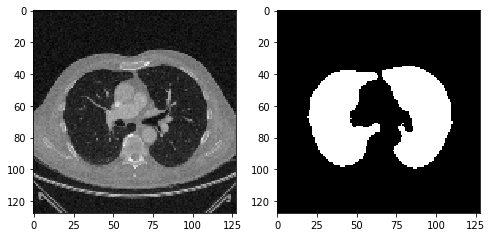

In [5]:
all_images1 = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images1), 128, 128), dtype='float32')
for i, name in enumerate(all_images1):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=( 128,128), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im
    
all_images2 = [x for x in sorted(os.listdir(MASK_LIB)) if x[-4:] == '.tif']
y_data = np.empty((len(all_images2),128, 128), dtype='float32')
for i, name in enumerate(all_images2):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED)
    if im is not None:
        im=im.astype('float32')/255.
        im = cv2.resize(im, dsize=( 128,128), interpolation=cv2.INTER_NEAREST)
        y_data[i] = im
    else:
        continue
        
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

In [7]:
x_train=np.reshape(x_train,(133, 128, 128, 1))
x_train.shape

(133, 128, 128, 1)

In [8]:
y_train=np.reshape(y_train,(133, 128, 128, 1))
y_train.shape

(133, 128, 128, 1)

In [9]:
x_val=np.reshape(x_val,(134, 128, 128, 1))
x_val.shape

(134, 128, 128, 1)

In [10]:
y_val=np.reshape(y_val,(134, 128, 128, 1))
y_val.shape

(134, 128, 128, 1)

In [11]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

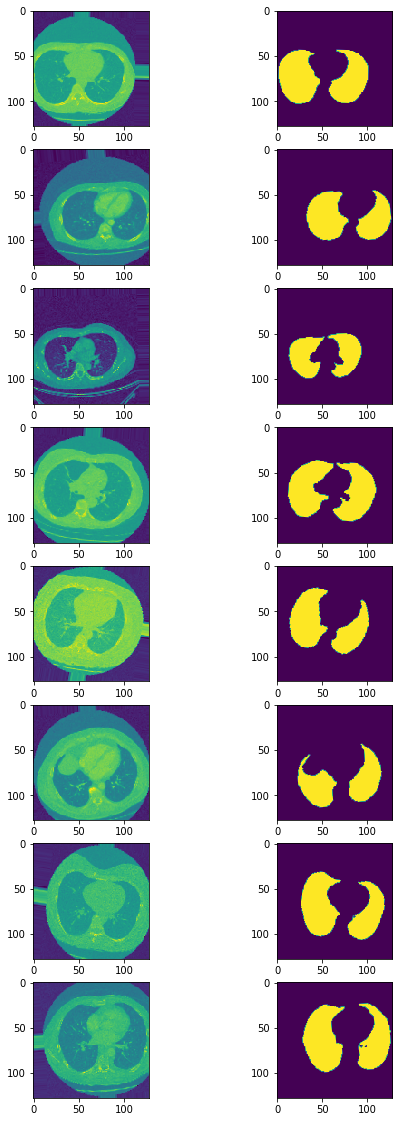

In [12]:
SEED=42
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [13]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [14]:
ist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
 - 1148s - loss: 0.1173 - dice_coef: 0.8666 - val_loss: 0.0668 - val_dice_coef: 0.9289
Epoch 2/10
 - 1098s - loss: 0.0562 - dice_coef: 0.9337 - val_loss: 0.3169 - val_dice_coef: 0.7532
Epoch 3/10
 - 1100s - loss: 0.0475 - dice_coef: 0.9426 - val_loss: 0.0630 - val_dice_coef: 0.9490
Epoch 4/10
 - 1130s - loss: 0.0398 - dice_coef: 0.9506 - val_loss: 0.0658 - val_dice_coef: 0.9511
Epoch 5/10
 - 1132s - loss: 0.0390 - dice_coef: 0.9519 - val_loss: 0.0609 - val_dice_coef: 0.9559
Epoch 6/10
 - 1114s - loss: 0.0352 - dice_coef: 0.9557 - val_loss: 0.0613 - val_dice_coef: 0.9556
Epoch 7/10
 - 1114s - loss: 0.0340 - dice_coef: 0.9574 - val_loss: 0.0624 - val_dice_coef: 0.9563
Epoch 8/10
 - 1114s - loss: 0.0337 - dice_coef: 0.9578 - val_loss: 0.0623 - val_dice_coef: 0.9581
Epoch 9/10
 - 1115s - loss: 0.0329 - dice_coef: 0.9589 - val_loss: 0.0616 - val_dice_coef: 0.9578
Epoch 10/10
 - 1113s - loss: 0.0325 - dice_coef: 0.9593 - val_loss: 0.0647 - val_dice_coef: 0.9554


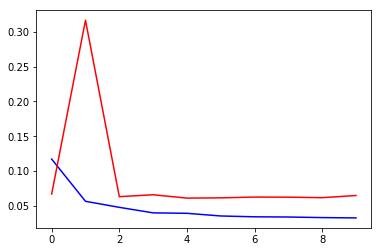

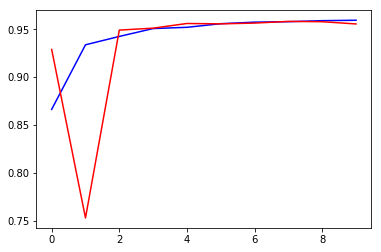

In [15]:
plt.plot(ist.history['loss'], color='b')
plt.plot(ist.history['val_loss'], color='r')
plt.show()
plt.plot(ist.history['dice_coef'], color='b')
plt.plot(ist.history['val_dice_coef'], color='r')
plt.show()

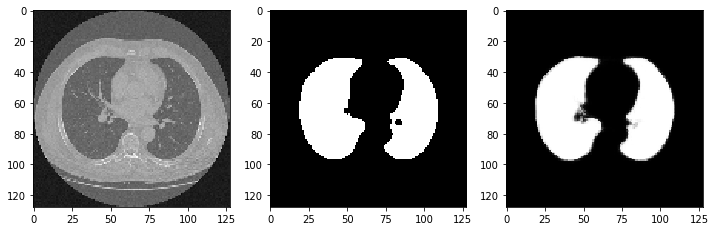

In [17]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[2,:,:,0], cmap='gray')
ax[1].imshow(y_val[2,:,:,0], cmap='gray')
ax[2].imshow(y_hat[2,:,:,0], cmap='gray')